In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
file = pd.read_excel('./41586_2009_BFnature07634_MOESM271_ESM.xls',
                     sheet_name=1,
                     header=1)

data = file.copy()

data['Date'] = pd.to_datetime(data['Date'])
data.head(5)

# plt.plot(data['Date'], data['United States'])
# plt.show()

In [7]:
column_name = []
for n in range(100):
    file = pd.read_excel('./41586_2009_BFnature07634_MOESM271_ESM.xls', sheet_name=n+1, header=0)
    column_name.append(file.columns[0])
print(column_name)

In [ ]:
data_wncr = data[['Date', 'West North Central Region']].rename(columns={'West North Central Region': column_name[0]})
for i in range(99):
    tmp = pd.read_excel('./41586_2009_BFnature07634_MOESM271_ESM.xls', sheet_name=i+2, header=1)
    data_wncr[f'{column_name[i+1]}'] = tmp['West North Central Region']
    print(column_name[i+1])

In [ ]:
data_wncr['Date'] = pd.to_datetime(data_wncr['Date'])
data_wncr.dtypes
data_wncr

In [19]:
ili = pd.read_csv('./ILINet.csv', header=1).loc[:, ['YEAR', 'WEEK', '% WEIGHTED ILI']]

# 结果误差可能原因：时间上出现偏差
ili['Date'] = pd.to_datetime(ili['YEAR'].astype(str) + ' ' + ili['WEEK'].astype(str) + ' 0', format='%Y %U %w')
ili

In [ ]:
res = pd.merge(data_wncr, ili[['Date', '% WEIGHTED ILI']], how='left', on='Date')
res = res.dropna(subset=['% WEIGHTED ILI']).iloc[:, 1:]
res

In [25]:
X = res.iloc[:, :-1]
y = res.iloc[:, [-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# xgbr = xgb.XGBRegressor(n_estimators=100)

# xgbr.fit(X_train, y_train)

# pred = xgbr.predict(X_test)

# r2 = r2_score(y_test, pred)
# mse = mean_squared_error(y_test, pred)
# print(r2)
# print(mse)

In [75]:
param_grid = {
    'subsample': [0.5, 0.6],
    'colsample_bytree': [0.5, 0.6]
}
xgbmodel = xgb.XGBRegressor(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=5000,
    gamma=0,
    alpha=0.1
)
grid_search = GridSearchCV(
    estimator=xgbmodel,
    param_grid=param_grid,
    cv=5
)
grid_search.fit(X_train, y_train, verbose=True)

GridSearchCV(cv=5,
             estimator=XGBRegressor(alpha=0.1, base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.01, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=5000,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.6],
                         'subsample': [0.5, 0.6]})

In [77]:
print("Best parameters found: ", grid_search.best_params_)
print("Best parameters found: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 0.5, 'subsample': 0.5}
Best parameters found:  0.8360487964133692


In [79]:
xgbr_best = grid_search.best_estimator_
pred = xgbr_best.predict(X_test)

In [81]:
np.sqrt(mean_squared_error(pred, y_test))

0.44631232329309106

In [ ]:
res_plt = pd.merge(data_wncr, ili[['Date', '% WEIGHTED ILI']], how='left', on='Date')
res_plt = res_plt.dropna(subset=['% WEIGHTED ILI'])
res_plt

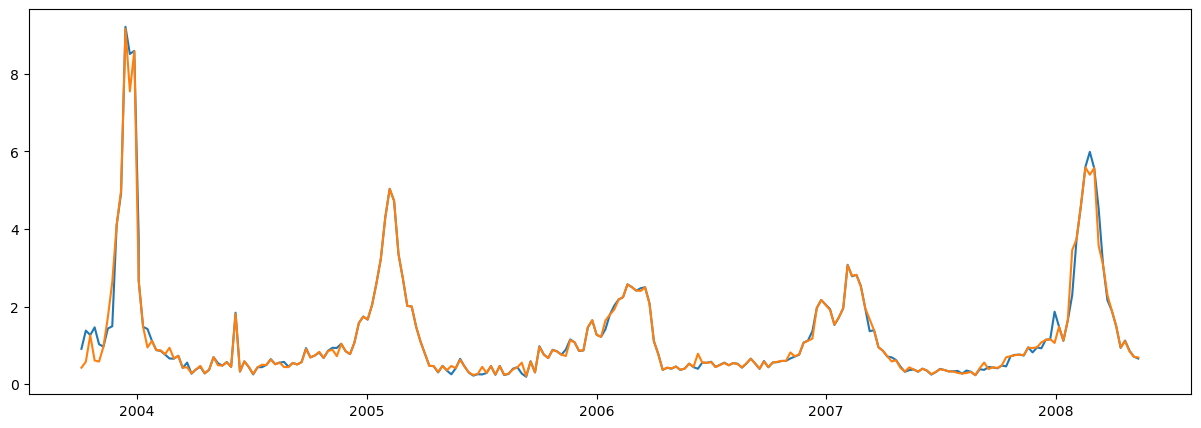

In [105]:
total_pred = xgbr_best.predict(X)
plt.rcParams.update({'figure.figsize': (15, 5)})
plt.plot(res_plt['Date'], res_plt['% WEIGHTED ILI'])
plt.plot(res_plt['Date'], total_pred)
plt.show()